In [1]:
# Import packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
import itertools
import numpy as np
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from fbprophet import Prophet


# Preferred settings
warnings.simplefilter("ignore")


<ipython-input-1-057088e0c8b3>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Import saved data
df_TS = pd.read_csv('Data/df_TS.csv')

# Set date column to datetime object
df_TS['Date'] = pd.to_datetime(df_TS['Date'])

# Set date column as index
df_TS.set_index('Date', inplace=True)

# Prepare Data

In [3]:
# Only use pre-COVID data for time series modeling
df_TS_preCOV = df_TS.loc[:'2020-3-13']


In [4]:
# Create df of only SI data, remove all columns other than accident counts 
df_prophet = df_TS_preCOV.drop(columns = ['Injuries', 'Deaths','Accidents_Bx', 'Accidents_Qns', 'Accidents_Bkln', 'Accidents_Man',
                               'Accidents_Total','Season','Day of Week', 'Weekend','Holiday'])

# Rename columns to [ds,y] per fb prophet specifications
df_prophet['ds'] = df_prophet.index
df_prophet.rename(columns={'Accidents_SI': 'y'},inplace=True)


In [5]:
df_prophet.head()

,y,ds
Date,,
2012-07-01,29.0,2012-07-01
2012-07-02,29.0,2012-07-02
2012-07-03,23.0,2012-07-03
2012-07-04,25.0,2012-07-04
2012-07-05,27.0,2012-07-05


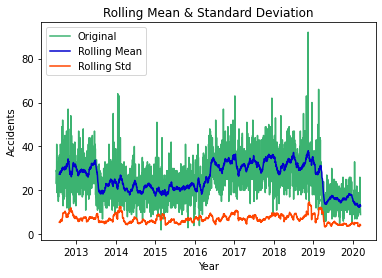

Test Statistic                   -2.474274
p-value                           0.121860
#Lags Used                       27.000000
Number of Observations Used    2783.000000
dtype: float64

In [6]:
# Visualize data, including 30-day rolling mean and standard deviation

roll_mean = df_prophet['y'].rolling(window=30, center=False).mean()
roll_std = df_prophet['y'].rolling(window=30, center=False).std()

plt.plot(df_prophet['y'],color='mediumseagreen', label='Original')
plt.plot(roll_mean, color='mediumblue', label='Rolling Mean')
plt.plot(roll_std, color='orangered', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(df_prophet['y'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

Based on the above visualization and Dickey-Fuller p-value, we see that this data is not stationary. Before fitting our model, we will perform differencing in an effort to achieve stationarity.

**Differencing**

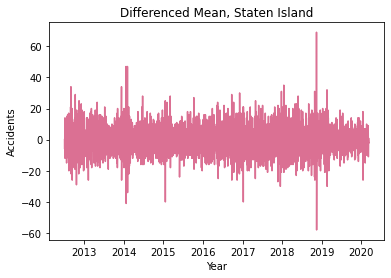

Test Statistic                -1.717901e+01
p-value                        6.665996e-30
#Lags Used                     2.600000e+01
Number of Observations Used    2.784000e+03
dtype: float64

In [8]:
# Difference data
diff = df_prophet['y'].diff()

# Plot differenced data
plt.plot(diff, color='palevioletred', label='Differenced Rolling Weekly Mean')
plt.title('Differenced Mean, Staten Island')
plt.xlabel('Year')
plt.ylabel('Accidents')
plt.show(block=False)

# Dickey-Fuller test
test = adfuller(diff[1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

We see above that differencing once achieved stationarity. We will use this differenced data to perform our model.

# Facebook Prophet Modeling

## Train-Test Split

In [12]:
# Re-format diff df to make usable with FB prophet
diff = pd.DataFrame(diff,columns=['y'])
diff['ds'] = diff.index

In [14]:
# Train-test split
# 2019-06-06 will be the split point for our train and test sets, which is a 90%/10% split

X = diff.index
y = diff[1:]

train = diff.loc[:'2019-06-06']
test = diff.loc['2019-06-07':]

X_train, X_test = train.index , test.index
y_train, y_test = train['y'], test['y']

## Fit Model and Generate Predictions

In [15]:
# Fit model to data
model = Prophet(interval_width=0.95)
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [16]:
# Make predictions 1120 days into the future--ie until 6/30/22
# This way we will have a full year of model-predicted data after starting on 7/1/21
# Create future dates
future_dates = model.make_future_dataframe(periods=1120, freq='D')

# Generate predictions
forecast = model.predict(future_dates)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3647,2022-06-26,-0.019308,-22.213967,13.135914,-0.019328,-0.019287,-4.586585,-4.586585,-4.586585,-4.235261,-4.235261,-4.235261,-0.351324,-0.351324,-0.351324,0.0,0.0,0.0,-4.605893
3648,2022-06-27,-0.019311,-11.204767,24.245056,-0.019331,-0.019290,5.874344,5.874344,5.874344,6.245511,6.245511,6.245511,-0.371166,-0.371166,-0.371166,0.0,0.0,0.0,5.855033
3649,2022-06-28,-0.019315,-17.858205,19.212027,-0.019335,-0.019293,0.943226,0.943226,0.943226,1.328981,1.328981,1.328981,-0.385756,-0.385756,-0.385756,0.0,0.0,0.0,0.923911
3650,2022-06-29,-0.019318,-17.651931,17.859010,-0.019338,-0.019297,0.304171,0.304171,0.304171,0.699016,0.699016,0.699016,-0.394844,-0.394844,-0.394844,0.0,0.0,0.0,0.284853
3651,2022-06-30,-0.019321,-18.474699,18.143480,-0.019341,-0.019300,-0.362397,-0.362397,-0.362397,0.035911,0.035911,0.035911,-0.398308,-0.398308,-0.398308,0.0,0.0,0.0,-0.381718


## Visualize Model

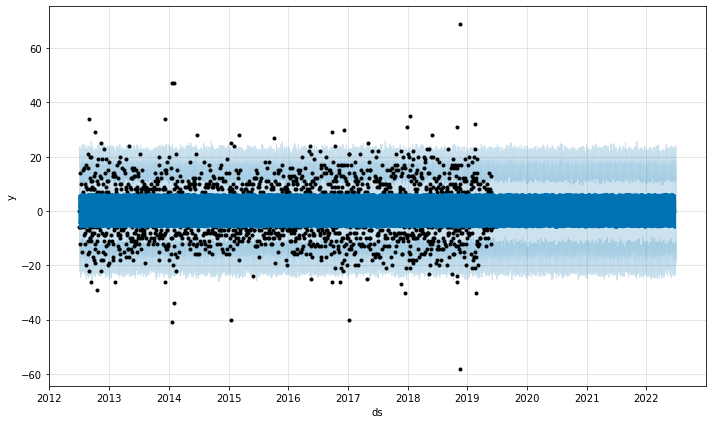

In [17]:
# Subset useful columns from forecast
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot forecast
model.plot(forecast,uncertainty=True)
plt.show()

## Assess Model

In [18]:
# Assess model using RMSE to compare to our working ARIMA model
# Create RMSE function
def RMSE(pred):
    return np.sqrt(((pred-y_test)**2).mean())

# Define test predictions
test_preds = forecast.set_index('ds').loc['2019-06-07':'2020-03-13']

# Define fb prophet RMSE
fb_RMSE = RMSE(test_preds['yhat'])

# Compare to ARIMA RMSE and adjusted RMSE to determine the better model
print('FB Prophet RMSE: ', fb_RMSE)
print('Adjusted FB Prophet RMSE: ', fb_RMSE/(diff.loc[:'2020-03-13']['y'].max()-diff.loc[:'2020-03-13']['y'].min()))
print('SARIMAX RMSE: ', 2.0628194296791666)
print('Adjusted SARIMAX RMSE: ', 0.06305561575438501)

FB Prophet RMSE:  6.59675131124586
Adjusted FB Prophet RMSE:  0.05194292371059732
SARIMAX RMSE:  2.0628194296791666
Adjusted SARIMAX RMSE:  0.06305561575438501


Based on the above adjusted RMSEs, we see that our FB Prophet model performs 18% better than our SARIMAX model. We will therefore consider this our best model.

Now that we know that this is our best model, we need to un-difference our predictions so they are representative of actual predicted accident count per day.

## Reverse Differencing in Predictions

In [20]:
# Identify last known value: 3/13/20
print(df_prophet.tail(1))

# Identify forecast index of first predicted value: 3/14/20
print(forecast[forecast['ds'] == '2020-03-14'])

              y         ds
Date                      
2020-03-13  9.0 2020-03-13
             ds      yhat  yhat_lower  yhat_upper
2813 2020-03-14 -6.173488  -24.045597   11.589264


In [21]:
# Create list of values with differencing reversed
rev_diff = []
y_prev = 9

# Start undifferencing at 3/14/20 since thats when our actualy predictions start. This is at index 2813.
for y in forecast['yhat'][2813:]:
    y_prev += y
    rev_diff.append(y_prev)

# Turn rev_diff into df with date column
rev_diff = pd.DataFrame(rev_diff, columns=['yhat'])
rev_diff['ds'] = pd.date_range(start='2020-03-14', end='2022-06-30')

## Adjust Predictions to Account for COVID

The above represents accident frequency predictions assuming the COVID-19 pandemic had not occured. Now we will adjust our predictions in the same way we did for our ARIMA model.

Car accidents in Staten Island have been much less affected by the pandemic than other boroughs have--a larger dip for them occured in the beginning of 2019 and only a much smaller one in March of 2020. We will therefore only diminish their predictions by 5% instead of 25%.

In [40]:
# Create Bronx dataframe with all known data, not only pre-COVID
df_SI_total = df_TS.drop(columns = ['Injuries', 'Deaths','Accidents_Bkln', 'Accidents_Man', 'Accidents_Qns', 'Accidents_Bx',
                               'Accidents_Total'])

# Create line connecting end of known data to predicted July data

# Begin model-based predictions on 7/1/21, diminish by 5%.
TS_pred_cov = rev_diff.set_index('ds').loc['2021-07-01':'2022-06-30']['yhat'] * 0.95

# Since there is more varibility in this model than there was in the ARIMA one and there is weekly seasonality,
# make 6/30/21 values the same as 7/7/2021 since they are the same day of the week
june_30 = TS_pred_cov.loc['2021-07-07']

# Create df for connection data
connection = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))
connection['Date'] = pd.DataFrame(pd.date_range(start='2021-01-30', end='2021-06-30'))

# Find how much the accident count will rise each day
# There are 151 days between 1/29/21 and 6/30/21
daily_interval=(june_30 - df_SI_total['Accidents_SI']['2021-01-29'])/151

# Add daily interval to each date in connection df
connection_forecasts = []
i = df_SI_total['Accidents_SI']['2021-01-29']
for num in range(0,151):
    i+=daily_interval
    connection_forecasts.append(i)
    
# Add 6/30/21 to forecases
connection_forecasts.append(june_30)
    
# Add list of forecasts to connection df
connection['Forecast'] = connection_forecasts

# Make date index of connection df
connection.set_index('Date', inplace=True)
connection.drop(columns=0,inplace=True)

#Observe connection df
connection

,Forecast
Date,
2021-01-30,6.936605
2021-01-31,6.873210
2021-02-01,6.809814
2021-02-02,6.746419
2021-02-03,6.683024
...,...
2021-06-26,-2.382495
2021-06-27,-2.445890
2021-06-28,-2.509286


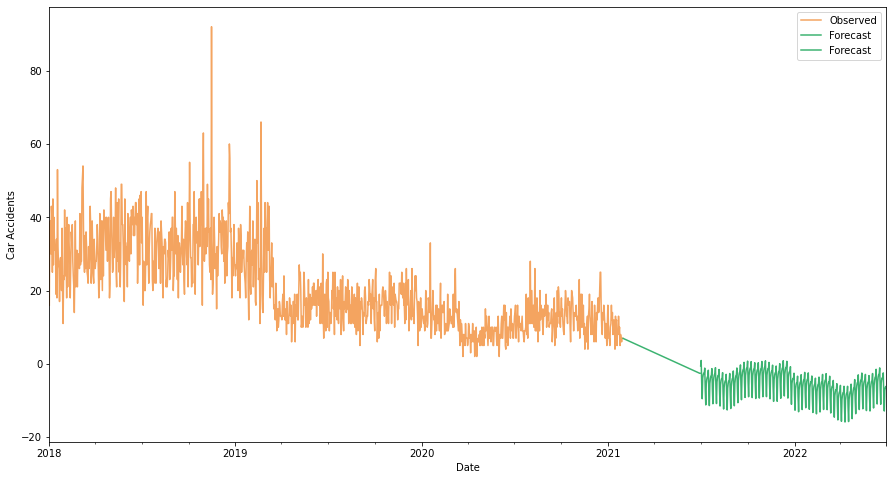

In [41]:
fix,ax = plt.subplots(figsize=(15,8))

# Plot known data
ax = df_SI_total['Accidents_SI']['2018-01-01':].plot(label='Observed', color='sandybrown')

# Plot predicted data based on model, starting 7/1/20, 95% of model prediction
TS_pred_cov.plot(ax=ax, label='Forecast', color='mediumseagreen')

# Plot linear connection
connection.plot(ax=ax, color='mediumseagreen')

ax.set_xlabel('Date')
ax.set_ylabel('Car Accidents')

plt.legend()
plt.show()

Although our adjusted RMSE looked best for this model, we see that these predictions are not realistic. Even though the Bronx is the borough with almost the fewest car accidents, these predictions are by far our highest. We will therefore count our SARIMAX model as our most accurate and use its predictions.